In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import rbf_kernel

class Kernel:
    
    condition = 1e-3 # add extra condition to reduce singular value issue
    
    @staticmethod
    def convert_to_float(num):
        return_val = np.float(num) if np.isscalar(num) else num
        return return_val
    
    @staticmethod
    def get(x_1, x_2, condition=1e-3): 
        K = rbf_kernel(x_1, x_2) # use sklearn's rbf_kernel()
        if type(x_1) == list:
            condition_matrix = condition * np.eye(K.shape[0]) if K.shape[0] == K.shape[1] else np.eye(K.shape[1])     
        else:
            condition_matrix = condition
        return (K + condition_matrix)

class GaussianProcess:
    
    def __init__(self, X, y, condition=1e-5):
        self.X = X
        self.y = y
        # precompute the covariance matrix and invert it
        self.k_x_x = Kernel.get(self.X,self.X, condition)
        self.inv_k_x_x = np.linalg.inv(self.k_x_x)

    def update(self, x, y, condition=1e-5):
        
        """
        x: new datapoint to incorporate
        y: corresponding output value(s) to incorporate
        condition: the σ^2(Ι) portion of the kernel, by default set to a small amount
        """
        
        self.X = np.concatenate((self.X,x), axis=0)
        self.y = np.concatenate((self.y,y), axis=0)
        
        # update the covariance matrix for existing training points
        self.k_x_x = Kernel.get(self.X,self.X, condition)
        self.inv_k_x_x = np.linalg.inv(self.k_x_x)
    
    def new_predict(self, x_new, noise=0):
        k_x_new_x = np.array([Kernel.get(x_new, np.array([x_i])).reshape(-1) for x_i in self.X])
        k_x_new_x_new = Kernel.get(x_new, x_new) # covariance matrix for new test points
        y_pred = np.dot(k_x_new_x.T, self.inv_k_x_x).dot(self.y) # Equation 2.23
        updated_sigma = k_x_new_x_new - np.dot(
            k_x_new_x.T, self.inv_k_x_x).dot(k_x_new_x) # Equation 2.24
        return y_pred.squeeze(), updated_sigma.squeeze() # using Fonnesbeck code here!
    
    def generate_predictions(self, prediction_interval, noise=0):
        predictions = [self.new_predict(np.array([[i]]), noise) for i in prediction_interval]
        # these next few lines are entirely from Chris Fonnesbeck's blog post at Domino Data Lab!
        y_pred, sigmas = np.transpose(predictions) 
        plt.errorbar(prediction_interval, y_pred, yerr=sigmas, capsize=1)
        plt.plot(self.X, self.y, "ro")
        plt.title(f"GP Predictions Given {len(self.y)} Training Points (In Red)")

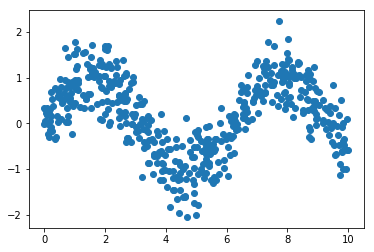

In [43]:
import numpy as np
θ = 3
bias = 100
X = np.array([np.random.uniform(0,10) for i in range(500)])
ε = np.array([np.random.normal(0,.4) for i in range(500)])
y = np.sin(X) + ε 
plt.scatter(X, y)

In [68]:
x_pred = np.linspace(0,10,100)
X = np.array([[5]])
y = np.array([[-.2]])
gp = GaussianProcess(X, y)

In [73]:
gp.update([[2]], [[.5]])
gp.update([[7]], [[.4]])
gp.update([[9]], [[-.7]])
gp.generate_predictions(x_pred)

LinAlgError: Singular matrix

In [67]:

gp = GaussianProcess([X[start]], [y[start]])
indices = range(len(prediction_interval))
for i in range(NUM_TRAINING_SAMPLES):
    start = np.random.choice(indices, replace=False)
    print(start)
    gp.update(X_sin[start], y_sin[start])
    
gp.generate_predictions(prediction_interval, noise=1e-7)
plt.scatter(X_sin, y_sin, c="orange", alpha=0.8)

IndexError: index 449 is out of bounds for axis 0 with size 1